In [1]:
import mdtraj as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances_argmin

from math import sqrt
import sys
import os

from datetime import date
from subprocess import call

In [2]:
project_dir = os.path.dirname(os.getcwd())

In [3]:
%%time
top = os.path.join(project_dir + "\\data\\DESRES-Trajectory_sarscov2-12366092-no-water\\sarscov2-12366092-no-water", "12366092Top.pdb")
nstxout = 10
stride = 1
skip = stride * nstxout
dt = 0.002

Wall time: 0 ns


In [4]:
trajname = os.path.join(project_dir + "\\data\\DESRES-Trajectory_sarscov2-12366092-no-water\\sarscov2-12366092-no-water", "12366092Traj.dcd") 
traj = md.load(trajname[:],  stride = stride, top = top)
traj_res = [str(r) for r in traj.top.residues]
print("Total of residues in the structure:", len(traj_res))
print("First residue of chain A:", traj_res[0])
print(len(traj))

Total of residues in the structure: 2669
First residue of chain A: ACE2
1000


In [26]:
cleft1_cA = []
for i in range (len(traj_res)):
    cleft1_cA.append(traj_res[i])    
    cleft_BS1 = [traj_res.index(r,) for r in cleft1_cA]
print("Number of residues in BS1:", len(cleft_BS1))  
pairs = list(itertools.combinations(cleft_BS1, 2))

Number of residues in BS1: 2669


In [27]:
def divide_chunks(l, n):
     #looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]
  
# How many elements each
# list should have
n = 35700
x = list(divide_chunks(pairs, n))

In [28]:
def get_sample():
    import random as r
    final_sample=[]
    for i in range(0,5000):
        for j in range(0,100):
            sample=r.choice(x[j])
            final_sample.append(sample)
            x[j].remove(sample)        
    return final_sample

In [29]:
desc = [(str(traj_res[int(p[0])]), str(traj_res[int(p[1])])) for p in pairs]

In [30]:
output_dir = os.path.join(project_dir + "\\data", "output_compressed.npz")

In [31]:
distances, indices = md.compute_contacts(traj, contacts = get_sample(), scheme = 'closest-heavy')

In [32]:
np.savez_compressed(output_dir, Y = distances, desc = desc)

In [33]:
distances.shape

(1000, 500000)

In [34]:
npz_file = np.load(output_dir, allow_pickle = True)

In [35]:
distance_Y = list(npz_file["Y"])
feat_des = npz_file["desc"]

In [36]:
random_state = 100

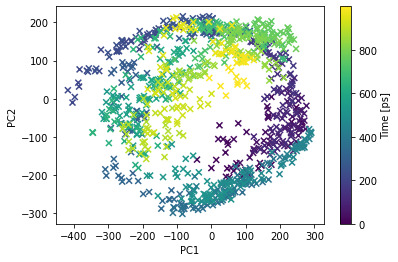

In [37]:
from sklearn.decomposition import PCA

pca_sklearn = PCA(random_state = random_state)
pca_components = pca_sklearn.fit_transform(distance_Y) * -1

plt.figure()
plt.scatter(pca_components[:, 0], pca_components[:,1], marker = 'x', c = traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

plt.show()

In [38]:
def _to_free_energy(z, minener_zero=False):

    pi = z / float(z.sum())
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = pi.nonzero()
    free_energy[nonzero] = -np.log(pi[nonzero])

    if minener_zero:
        free_energy[nonzero] -= np.min(free_energy[nonzero])
    return free_energy

In [39]:
 def get_histogram(
        xall, yall, nbins = 100,
        weights = None, avoid_zero_count = False):
  
    z, xedge, yedge = np.histogram2d(
        xall, yall, bins = nbins, weights = weights)
    
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])

    if avoid_zero_count:
        z = np.maximum(z, np.min(z[z.nonzero()]))
    return x, y, z.T

In [40]:
x, y, z = get_histogram(pca_components[:,0], pca_components[:,1])

In [41]:
kT = 1.0
f = _to_free_energy(z, minener_zero =  True) * kT

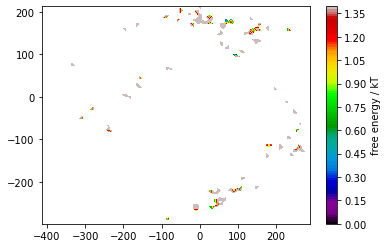

In [42]:
import matplotlib.pyplot as _plt

fig, ax = _plt.subplots()
mappable = ax.contourf(
    x, y, f, 100, norm = None,
    vmin = None, vmax = None, cmap = 'nipy_spectral',
    levels = None)

misc = dict(mappable = mappable)
cbar_ = fig.colorbar(
    mappable, ax = None, orientation = 'vertical')
cbar_.set_label('free energy / kT')

plt.show()

In [43]:
pca_eigenvalues = pca_sklearn.explained_variance_ratio_

In [44]:
 pc_id = list(range(len(pca_eigenvalues)))

In [45]:
pca_eigen_df = pd.DataFrame({"pc_id": pc_id, "eig_cum": np.cumsum(pca_eigenvalues), "eig_values": pca_eigenvalues})

In [46]:
pca_eigen_df.head()

,pc_id,eig_cum,eig_values
0,0,0.292472,0.292472
1,1,0.538935,0.246463
2,2,0.706755,0.167820
3,3,0.771236,0.064481
4,4,0.828573,0.057337


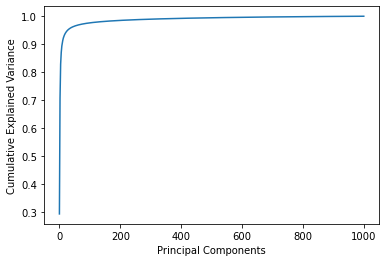

In [47]:
plt.plot(np.cumsum(pca_eigenvalues))
plt.xlabel("Principal Components")
plt.ylabel('Cumulative Explained Variance')
plt.show()

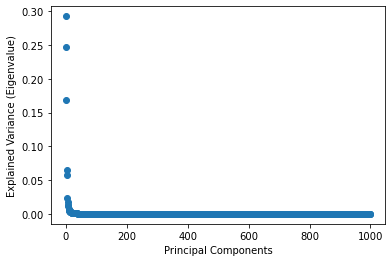

In [48]:
plt.scatter(np.arange(len(pca_eigenvalues)), pca_eigenvalues)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (Eigenvalue)")
plt.show()

In [49]:
n_pca = pca_eigen_df[pca_eigen_df['eig_cum'] <= 0.7]
n_pca = n_pca.shape[0]

In [50]:
print(n_pca)

2


In [51]:
def optimal_number_of_clusters(wcss):
    # Function to define the optimal number of clusters
    x1, y1 = 1, wcss[0]
    x2, y2 = 100, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [52]:
 pca_components_df = pd.DataFrame(pca_components)

In [53]:
X = pca_components_df.iloc[:,:n_pca]
X.shape

(1000, 2)

In [54]:
inertias = []
K = range(1, 100)

for k in K:
    model = KMeans(n_clusters = k, random_state = random_state)
    model.fit(X)
    inertias.append(model.inertia_)

C:\Users\Mondello\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


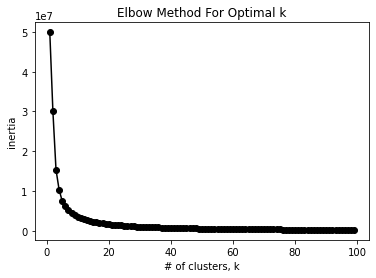

In [64]:
def plot_inertia():
    plt.plot(K, inertias, '-o', color='black')
    plt.xlabel('# of clusters, k')
    plt.ylabel('inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()
plot_inertia()    

In [56]:
n = optimal_number_of_clusters(inertias)
print("Optimal number of clusters: ", n)

Optimal number of clusters:  10


In [57]:
km = KMeans(n_clusters = n)
km = km.fit(X)

In [58]:
OPTIONAL = True
execution = date.today().strftime('%Y-%m-%d')

closest = pairwise_distances_argmin(km.cluster_centers_, X)
representatives = []

try:
    os.makedirs(os.path.join(project_dir + "/data/" + "clusters", execution))
except OSError:
    print ("Creation of the directory %s failed" % execution)
else:
    print ("Successfully created the directory %s " % execution)

for i in enumerate(closest):
    traj_index = int((i[1]-1) / traj.n_frames)
    frame_index = i[1]-(traj_index * traj.n_frames)

    n_cluster = str(i[0])
    
    representatives.append([traj_index, frame_index, i[1]])
    print(f"Closest conformation inside cluster {n_cluster} can be found in trajectory {traj_index} frame {frame_index}, (index {i[1]})")

    if OPTIONAL:   
        convert_command = f"mdconvert {trajname} -t {top} -o {project_dir}/data/clusters/{execution}/PCA_in_cluster_{n_cluster}_{frame_index}.pdb -i {frame_index}"        
        print(convert_command)

        call(convert_command, shell = True)

Successfully created the directory 2021-07-01 
Closest conformation inside cluster 0 can be found in trajectory 0 frame 711, (index 711)
mdconvert C:\Users\data\DESRES-Trajectory_sarscov2-12366092-no-water\sarscov2-12366092-no-water\12366092Traj.dcd -t C:\Users\data\DESRES-Trajectory_sarscov2-12366092-no-water\sarscov2-12366092-no-water\12366092Top.pdb -o C:\Users/data/clusters/2021-07-01/PCA_in_cluster_0_711.pdb -i 711
Closest conformation inside cluster 1 can be found in trajectory 0 frame 497, (index 497)
mdconvert C:\Users\data\DESRES-Trajectory_sarscov2-12366092-no-water\sarscov2-12366092-no-water\12366092Traj.dcd -t C:\Users\data\DESRES-Trajectory_sarscov2-12366092-no-water\sarscov2-12366092-no-water\12366092Top.pdb -o C:\Users/data/clusters/2021-07-01/PCA_in_cluster_1_497.pdb -i 497
Closest conformation inside cluster 2 can be found in trajectory 0 frame 306, (index 306)
mdconvert C:\Users\data\DESRES-Trajectory_sarscov2-12366092-no-water\sarscov2-12366092-no-water\12366092Traj.

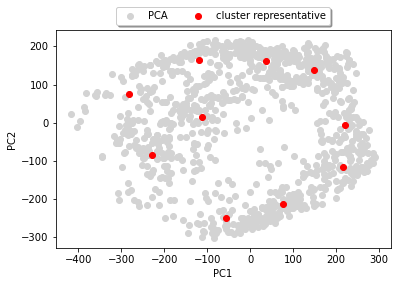

In [63]:
def plot_cluster_rep():
    plt.scatter(pca_components[:,0], pca_components[:,1], c="lightgrey")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    [plt.scatter(pca_components[yr[2],0], pca_components[yr[2],1], c="red") for yr in representatives]

    plt.legend(["PCA", "cluster representative"], loc='upper center', bbox_to_anchor=(0.5, 1.13), fancybox=True, shadow=True, ncol=5)

    plt.show()
plot_cluster_rep()    

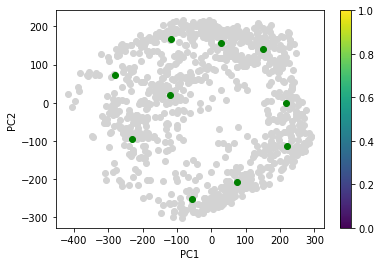

In [61]:
def plot_centroids():
    cc = km.cluster_centers_

    #plotting all elements
    plt.scatter(pca_components_df.iloc[:, 0], pca_components_df.iloc[:, 1], c = "lightgrey")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # plotting cluster centers
    plt.scatter(cc[:, 0], cc[:, 1], c="green") 
    plt.colorbar()
    plt.show()
plot_centroids()    